<a href="https://colab.research.google.com/github/ShahedSabab/forecast-energy-consumption/blob/master/Forecast_energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
!pip install pmdarima
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

# EDA

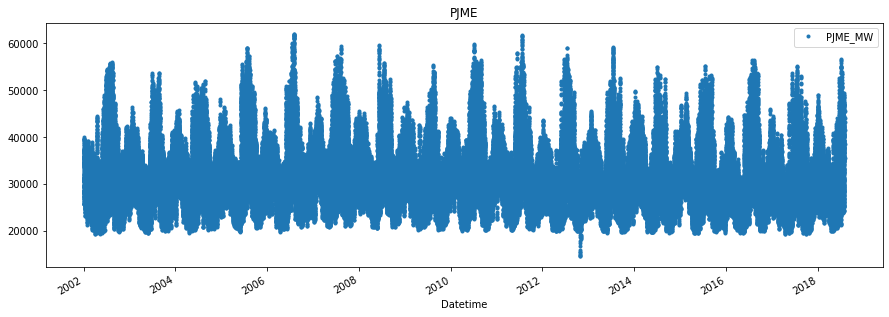

In [149]:
# Set index column and parse date
df = pd.read_csv('PJME_hourly.csv',index_col=[0], parse_dates=[0])
df.plot(style = '.', figsize = (15,5), title = 'PJME')

In [150]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [151]:
def feature_engineering(df, label):
  '''
  create features from the time series
  '''
  df = df.copy()
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour 
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['quarter'] = df['date'].dt.quarter
  df['dayofweek'] = df['date'].dt.dayofweek
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear

  X = df[['hour', 'dayofmonth', 'month', 'year', 'quarter', 'dayofweek', 'weekofyear', 'dayofyear']]
  y= df[label]

  return X, y


In [152]:
X, y = feature_engineering(df, label = 'PJME_MW')
df_new = pd.concat([X,y], axis = 1)
df_new[df_new['weekofyear']==30]

,hour,dayofmonth,month,year,quarter,dayofweek,weekofyear,dayofyear,PJME_MW
Datetime,,,,,,,,,
2002-07-28 01:00:00,1,28,7,2002,3,6,30,209,29605.0
2002-07-28 02:00:00,2,28,7,2002,3,6,30,209,27994.0
2002-07-28 03:00:00,3,28,7,2002,3,6,30,209,26806.0
2002-07-28 04:00:00,4,28,7,2002,3,6,30,209,26094.0
2002-07-28 05:00:00,5,28,7,2002,3,6,30,209,25725.0
...,...,...,...,...,...,...,...,...,...
2018-07-23 21:00:00,21,23,7,2018,3,0,30,204,41745.0
2018-07-23 22:00:00,22,23,7,2018,3,0,30,204,40395.0
2018-07-23 23:00:00,23,23,7,2018,3,0,30,204,37727.0


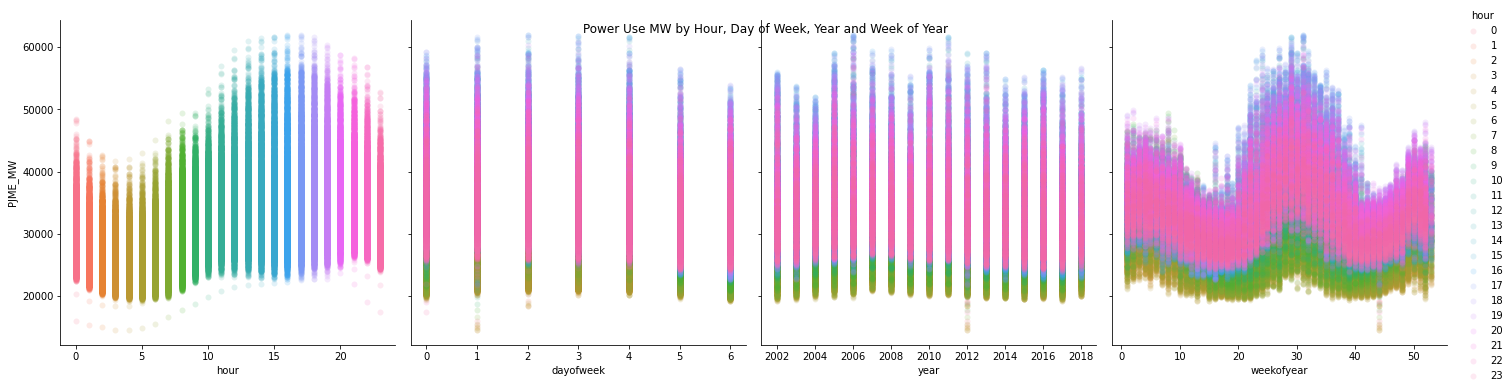

In [153]:
sns.pairplot(df_new,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

Power consumption has daily, weekly and seasonal properties. If we see the hourly consuption then during 1-8 pm we see the peak. In case of the weekly consumption, we see the lowest is during the weekend (dayofweek = 5 & 6). The highest consumption of energy throughout the year is during week 30 which is the month of July (Summer season). 

In [154]:
df_new

,hour,dayofmonth,month,year,quarter,dayofweek,weekofyear,dayofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,31,12,2002,4,1,1,365,26498.0
2002-12-31 02:00:00,2,31,12,2002,4,1,1,365,25147.0
2002-12-31 03:00:00,3,31,12,2002,4,1,1,365,24574.0
2002-12-31 04:00:00,4,31,12,2002,4,1,1,365,24393.0
2002-12-31 05:00:00,5,31,12,2002,4,1,1,365,24860.0
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,1,1,2018,1,0,1,1,44284.0
2018-01-01 21:00:00,21,1,1,2018,1,0,1,1,43751.0
2018-01-01 22:00:00,22,1,1,2018,1,0,1,1,42402.0


split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()
pjme_train

In [155]:
# Take the sum of the hourly values per day to calculate total energy consumption per day 
df_monthly = df_new.resample('M').PJME_MW.sum().reset_index()
# Get rid of the last row
df_monthly = df_monthly.iloc[:-1]
df_monthly = df_monthly.set_index('Datetime')
df_monthly

,PJME_MW
Datetime,
2002-01-31,23089022.0
2002-02-28,20320720.0
2002-03-31,21483191.0
2002-04-30,20516472.0
2002-05-31,20886798.0
...,...
2018-03-31,22615842.0
2018-04-30,19694352.0
2018-05-31,21278364.0


# Train-Test Split

In [156]:
split_date = '31-12-2014'
df_train = df_monthly.loc[df_monthly.index <= split_date].copy()
df_test = df_monthly.loc[df_monthly.index > split_date].copy()

test_per = df_test.shape[0]/df_monthly.shape[0]
print("Train : Test = {} : {}".format( 1-test_per, test_per))

Train : Test = 0.7839195979899498 : 0.21608040201005024


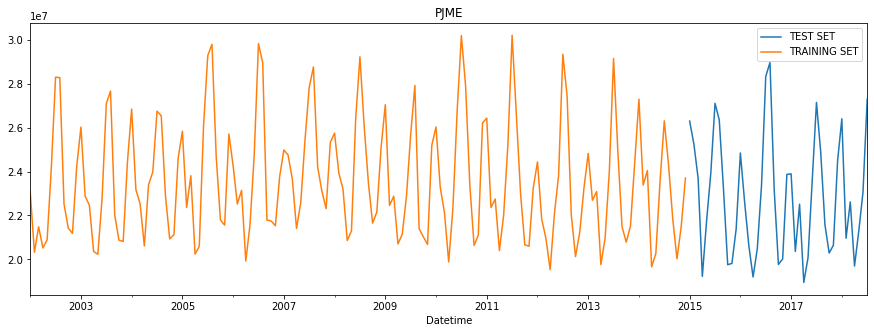

In [157]:
#Plot train and test
df_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJME', style='-')
plt.show()


# Performance Metric

In [158]:
def performance_metric(y_true, y_pred):
  '''
  Calculate errors from the real 
  '''
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
  r2 = r2_score(y_true,y_pred)
  return mse, mae, mape, r2

# Plot 

In [159]:
def plot_test(y_true, y_pred, test_data):
  '''
  plot and compare predicted result
  '''
  # test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
  # import seaborn as sns
  plt.figure(figsize=(16,5))
  ax = sns.lineplot(x= test_data.index, y=y_true, label='True')
  bx = sns.lineplot(x=test_data.index, y = y_pred, label = 'Predicted')
  plt.legend()
  plt.show()

# Prophet Model

In [160]:
# Prophet require the attributes to be ds and y
df_train_pr = df_train.reset_index().rename(columns = {'Datetime':'ds', 'PJME_MW': 'y'})
df_test_pr = df_test.reset_index().rename(columns = {'Datetime':'ds'})

In [161]:
df_train_pr

,ds,y
0,2002-01-31,23089022.0
1,2002-02-28,20320720.0
2,2002-03-31,21483191.0
3,2002-04-30,20516472.0
4,2002-05-31,20886798.0
...,...,...
151,2014-08-31,24318494.0
152,2014-09-30,21847173.0
153,2014-10-31,20023461.0
154,2014-11-30,21486203.0


In [162]:
# set the model parameter
model = Prophet()
model.fit(df_train_pr)
future = model.make_future_dataframe(periods = df_test.shape[0], freq='M')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [163]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-01-31,2.294876e+07,2.383786e+07,2.615357e+07,2.294876e+07,2.294876e+07,2.082665e+06,2.082665e+06,2.082665e+06,2.082665e+06,2.082665e+06,2.082665e+06,0.0,0.0,0.0,2.503142e+07
1,2002-02-28,2.296788e+07,2.093447e+07,2.344298e+07,2.296788e+07,2.296788e+07,-7.431694e+05,-7.431694e+05,-7.431694e+05,-7.431694e+05,-7.431694e+05,-7.431694e+05,0.0,0.0,0.0,2.222471e+07
2,2002-03-31,2.298905e+07,2.114556e+07,2.348209e+07,2.298905e+07,2.298905e+07,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,0.0,0.0,0.0,2.229028e+07
3,2002-04-30,2.300954e+07,1.859250e+07,2.100536e+07,2.300954e+07,2.300954e+07,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,0.0,0.0,0.0,1.977300e+07
4,2002-05-31,2.303071e+07,1.964046e+07,2.199037e+07,2.303071e+07,2.303071e+07,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,0.0,0.0,0.0,2.086172e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2018-03-31,2.225134e+07,2.036713e+07,2.287735e+07,2.210686e+07,2.238319e+07,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,-6.987733e+05,0.0,0.0,0.0,2.155256e+07
195,2018-04-30,2.223638e+07,1.774913e+07,2.017670e+07,2.208463e+07,2.237395e+07,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,-3.236533e+06,0.0,0.0,0.0,1.899985e+07
196,2018-05-31,2.222092e+07,1.883247e+07,2.125848e+07,2.206400e+07,2.236758e+07,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,-2.168991e+06,0.0,0.0,0.0,2.005193e+07
197,2018-06-30,2.220596e+07,2.202730e+07,2.447028e+07,2.204557e+07,2.236115e+07,1.005860e+06,1.005860e+06,1.005860e+06,1.005860e+06,1.005860e+06,1.005860e+06,0.0,0.0,0.0,2.321182e+07


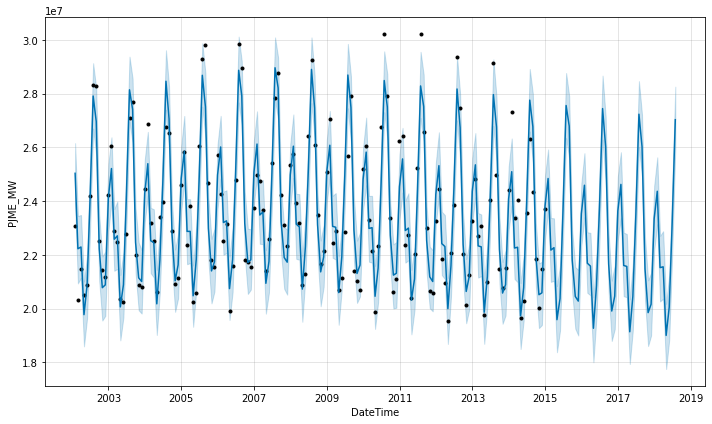

In [164]:
# Check prediction
figure = model.plot(forecast, xlabel = 'DateTime', ylabel = 'PJME_MW')

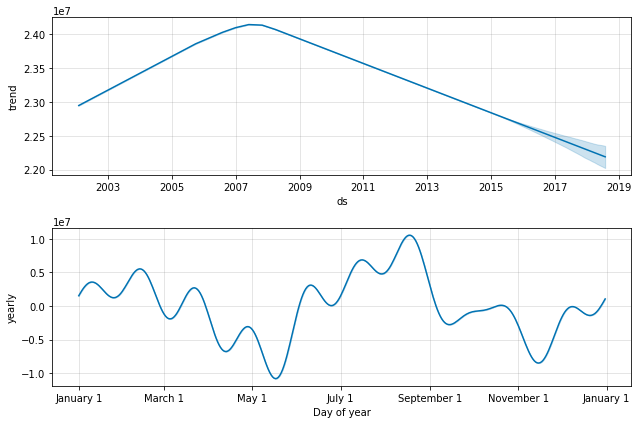

In [165]:
# Plot the components
figure2 = model.plot_components(forecast)

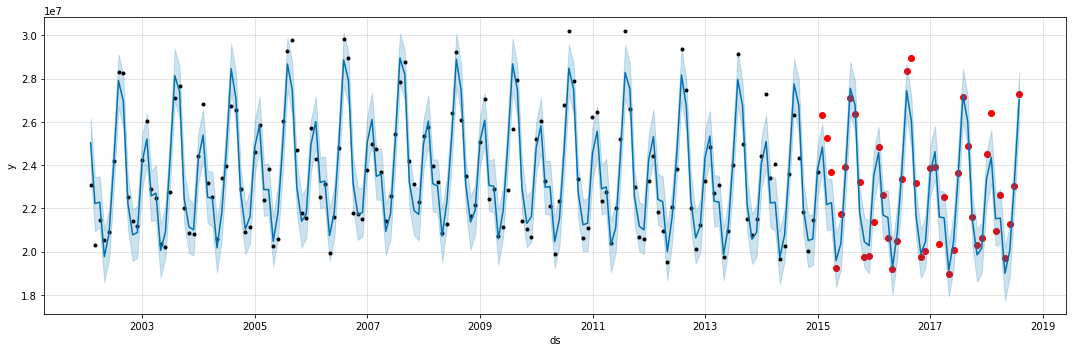

In [166]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(forecast, ax=ax)

In [167]:
# Performance analysis
mse, mae, mape, r2 = performance_metric(df_test['PJME_MW'], forecast.iloc[-df_test.shape[0]:]['yhat'])

In [168]:
print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))
print("R2: {}%".format(r2))

MSE: 1201622561728.1304
MAE: 833000.8900713924
MAPE: 3.5699381630854226%
R2: 0.837517275909495%


In [169]:
# Save it to a dataframe
df_test_final = df_test.copy()
df_test_final['Prophet'] = forecast.iloc[-df_test.shape[0]:]['yhat'].values
data = {'model': 'Prophet', 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2' : r2}
df_performance = pd.DataFrame(data, index=[0])

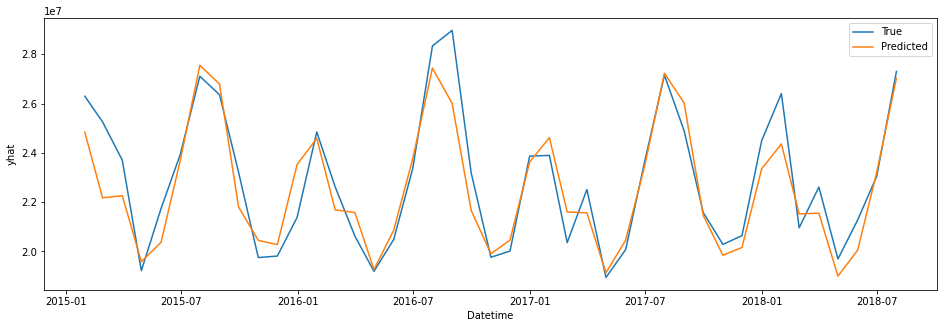

In [170]:
plot_test(df_test['PJME_MW'], forecast.iloc[-df_test.shape[0]:]['yhat'], df_test)

# Adding holidays with Prophet

In [171]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
train_holidays = cal.holidays(start=df_train.index.min(), end=df_train.index.max())
test_holidays = cal.holidays(start=df_test.index.min(), end=df_test.index.max())

In [172]:
# Create a dataframe with holiday, ds columns
df_temp = df_monthly.copy()
df_temp['date'] = df_temp.index.date
df_temp['is_holiday'] = df_temp.date.isin([d.date() for d in cal.holidays()])
df_temp
df_holiday = df_temp.loc[df_temp['is_holiday']].reset_index()
df_holiday = df_holiday.rename(columns={'Datetime':'ds'})
df_holiday['holiday'] = 'USFederalHoliday'
df_holiday = df_holiday.drop(['PJME_MW','date','is_holiday'], axis=1)
df_holiday

,ds,holiday
0,2004-05-31,USFederalHoliday
1,2004-12-31,USFederalHoliday
2,2010-05-31,USFederalHoliday
3,2010-12-31,USFederalHoliday


In [173]:
df_holiday['ds'] = pd.to_datetime(df_holiday['ds'])
df_holiday

,ds,holiday
0,2004-05-31,USFederalHoliday
1,2004-12-31,USFederalHoliday
2,2010-05-31,USFederalHoliday
3,2010-12-31,USFederalHoliday


In [174]:
# Setup the Prophet model
model_holiday = Prophet(holidays = df_holiday)
model_holiday.fit(df_train_pr)
future_holiday = model_holiday.make_future_dataframe(periods = df_test.shape[0], freq='M')
forecast_holiday = model_holiday.predict(future_holiday)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


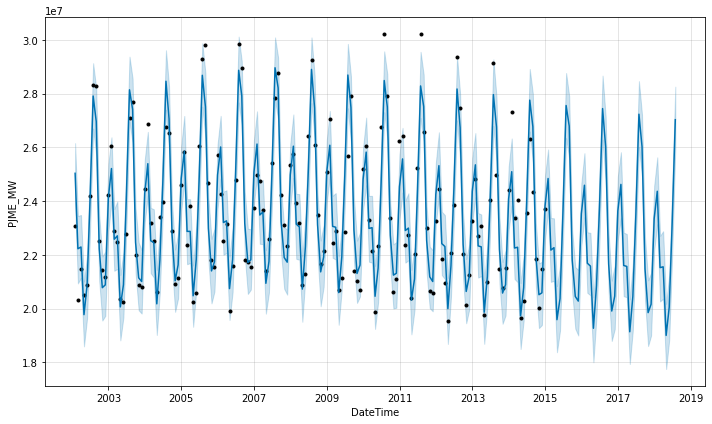

In [175]:
# Check prediction
figure = model_holiday.plot(forecast, xlabel = 'DateTime', ylabel = 'PJME_MW')

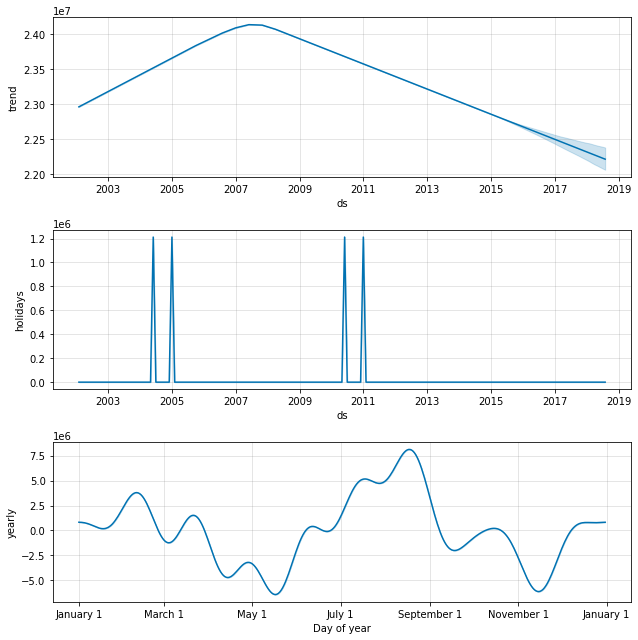

In [176]:
# Plot the components
figure2 = model_holiday.plot_components(forecast_holiday)

In [177]:
# Performance analysis
mse, mae, mape, r2 = performance_metric(df_test['PJME_MW'], forecast_holiday.iloc[-df_test.shape[0]:]['yhat'])

In [178]:
print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))
print("R2: {}%".format(r2))

MSE: 1210321606765.2214
MAE: 832205.3634843248
MAPE: 3.5642284720904795%
R2: 0.836340995953017%


In [179]:
# Save the results to a dataframe
df_test_final['Prophet-Holiday'] = forecast_holiday.iloc[-df_test.shape[0]:]['yhat'].values
data = {'model': 'Prophet-holiday', 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2' : r2}
df_performance = df_performance.append(data, ignore_index=True)

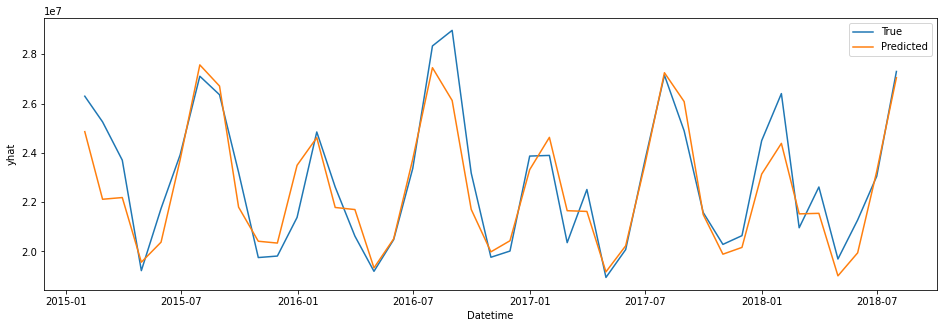

In [180]:
plot_test(df_test['PJME_MW'], forecast_holiday.iloc[-df_test.shape[0]:]['yhat'], df_test)

# LSTM Forecast

In [181]:
# Normalzie the data
scaler = MinMaxScaler()
scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

In [182]:
# Fit the model
n_input = 12
n_features= 1

generator = TimeseriesGenerator(df_train_scaled, df_train_scaled, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(200,activation="relu",return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))


lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 12, 200)           161600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [183]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
144/144 [==============================] - 7s 47ms/step - loss: 0.0792
Epoch 2/20
144/144 [==============================] - 6s 44ms/step - loss: 0.0649
Epoch 3/20
144/144 [==============================] - 6s 43ms/step - loss: 0.0536
Epoch 4/20
144/144 [==============================] - 6s 45ms/step - loss: 0.0429
Epoch 5/20
144/144 [==============================] - 6s 44ms/step - loss: 0.0328
Epoch 6/20
144/144 [==============================] - 6s 45ms/step - loss: 0.0205
Epoch 7/20
144/144 [==============================] - 6s 45ms/step - loss: 0.0273
Epoch 8/20
144/144 [==============================] - 6s 45ms/step - loss: 0.0226
Epoch 9/20
144/144 [==============================] - 6s 45ms/step - loss: 0.0240
Epoch 10/20
144/144 [==============================] - 6s 44ms/step - loss: 0.0235
Epoch 11/20
144/144 [==============================] - 6s 44ms/step - loss: 0.0205
Epoch 12/20
144/144 [==============================] - 6s 44ms/step - loss: 0.0221
Epoch 13/20
1

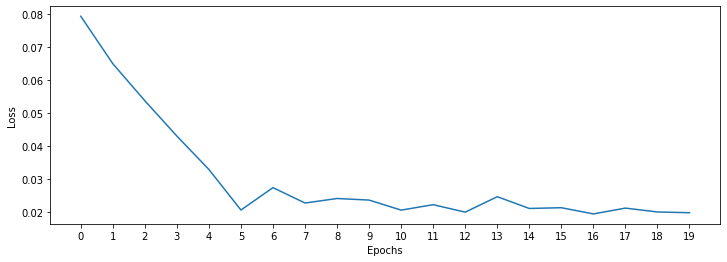

In [184]:
# Check loss over epochs
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [185]:
# Get the predicted results
lstm_predictions_scaled = list()

batch = df_train_scaled[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [186]:
# Get the real predicted data from the normalized data
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [187]:
# Performance Analysis
df_test_final['LSTM_Predictions'] = lstm_predictions
mse, mae, mape, r2 = performance_metric(df_test_final['PJME_MW'], df_test_final['LSTM_Predictions'])
# Save the results to a dataframe
data = {'model': 'LSTM', 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2' : r2}
df_performance = df_performance.append(data, ignore_index=True)

In [188]:
print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))
print("R2: {}%".format(r2))

MSE: 2901588665577.759
MAE: 1393993.2771092989
MAPE: 6.175442012171892%
R2: 0.6076488195301746%


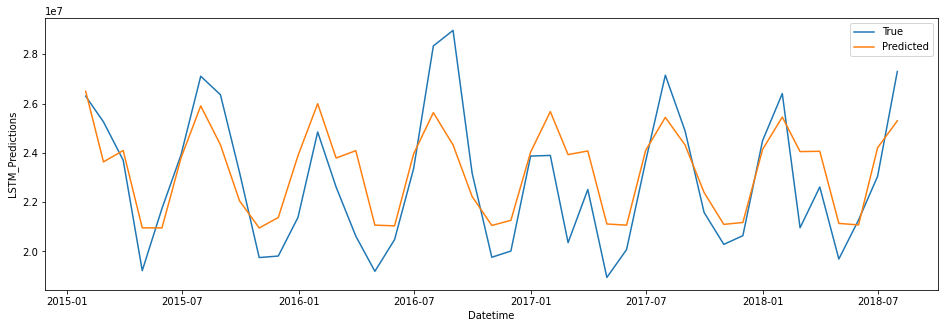

In [189]:
plot_test(df_test_final['PJME_MW'], df_test_final['LSTM_Predictions'], df_test_final)

In [190]:
df_performance

,model,MSE,MAE,MAPE,R2
0,Prophet,1.201623e+12,8.330009e+05,3.569938,0.837517
1,Prophet-holiday,1.210322e+12,8.322054e+05,3.564228,0.836341
2,LSTM,2.901589e+12,1.393993e+06,6.175442,0.607649


# ARIMA model

In [191]:
#Check if the data is stationary
def adfuller_test(sales):
  '''
  Dicky fullers test to check the stationarity of the data
  '''
  result=adfuller(sales)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )
  if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
  else:
      print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [192]:
adfuller_test(df_monthly['PJME_MW'])

ADF Test Statistic : -1.8467926046791063
p-value : 0.3574901625170562
#Lags Used : 15
Number of Observations Used : 183
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


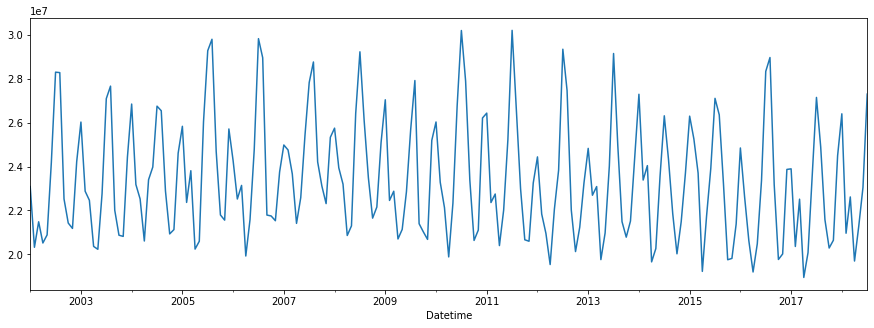

In [193]:
df_monthly['PJME_MW'].plot(figsize=(15,5))

In [194]:
# Make the data stationary
df_monthly['Seasonal First Difference']=df_monthly['PJME_MW']-df_monthly['PJME_MW'].shift(12)
adfuller_test(df_monthly['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.69405986870809
p-value : 8.634177223793697e-05
#Lags Used : 12
Number of Observations Used : 174
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


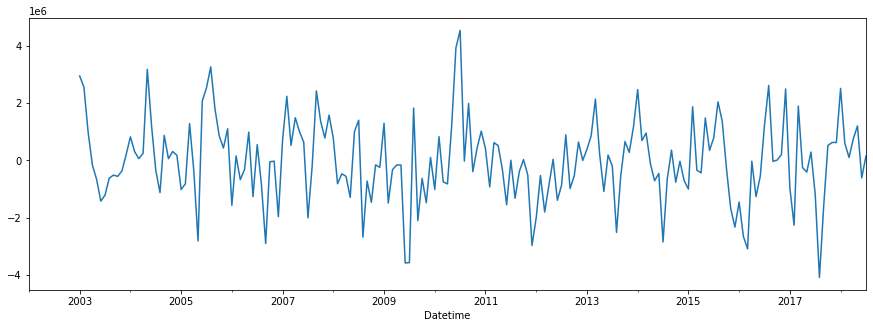

In [195]:
df_monthly['Seasonal First Difference'].plot(figsize=(15,5))

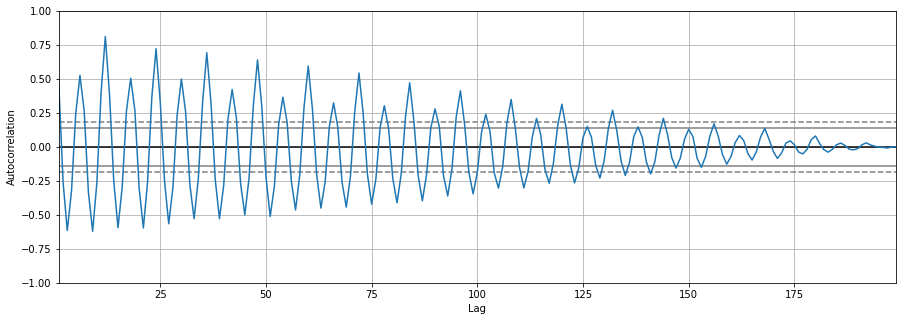

In [196]:
# autocorrelation plot
autocorrelation_plot(df_monthly['PJME_MW'])
plt.show()

We need to figure out p,d and q before fitting the data to the ARIMA model. 
```
P: Auto-regression (AR) model lags
d: Differencing
q: Moving average (MA) lags 
```
```
Identification of the AR model is done with PACF (Partial auto correlation)
Identification of the MA model is done with ACF (Auto Correlation)
``` 

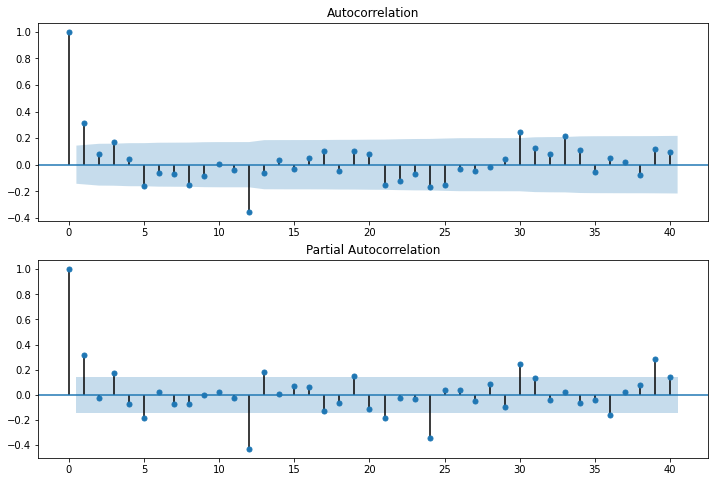

In [197]:
# Plot PACF and ACF to get a sense of the values to set for p, d, and q
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_monthly['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_monthly['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

From the graphs, we will look for the "shut offs" (drastic change). In this case, both the change seems to be prominent in 1. So, we choose p=1 and q=1
 

In [198]:
model=sm.tsa.statespace.SARIMAX(df_train['PJME_MW'],order=(1,1,1), seasonal_order=(1,1,1,12)) 
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            PJME_MW   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2227.290
Date:                            Mon, 20 Jul 2020   AIC                           4464.580
Time:                                    03:24:45   BIC                           4479.394
Sample:                                01-31-2002   HQIC                          4470.600
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1072      0.357      0.300      0.764      -0.593       0.807
ma.L1         -0.2667      0.351     -0.760      0.447      -0.954       0.421
ar.S.L12       0.4028      0.089      4.526      0.000       0.228       0.577
ma.S.L12      -0.8322      0.120     -6.926      0.000      -1.068      -0.597
sigma2      2.043e+12   2.53e-13   8.07e+24      0.000    2.04e+12    2.04e+12
===================================================================================
Ljung-Box (Q):                      101.88   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               0.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+41. Standard errors may be unstable.
"""

In [199]:
df_test_final['SARIMAX']=model_fit.predict(start=df_train.shape[0],end=df_monthly.shape[0],dynamic=True)

In [200]:
# Performance Analysis
mse, mae, mape, r2 = performance_metric(df_test_final['PJME_MW'], df_test_final['SARIMAX'])

In [201]:
print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))
print("R2: {}%".format(r2))

MSE: 1856683464974.9895
MAE: 1117548.609720509
MAPE: 4.9794528735522245%
R2: 0.7489403105671799%


In [202]:
# Save the results to a dataframe
data = {'model': 'SARIMAX', 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2' : r2}
df_performance = df_performance.append(data, ignore_index=True)

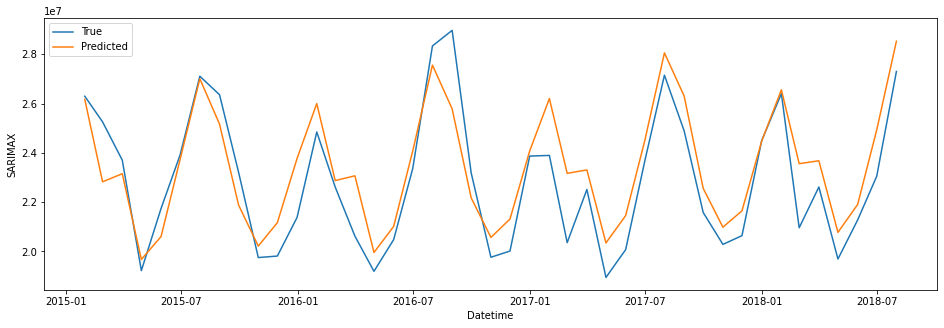

In [203]:
plot_test(df_test_final['PJME_MW'], df_test_final['SARIMAX'], df_test_final)

In [204]:
# Tune model paramters using auto arima
auto_arima(df_test_final['PJME_MW'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/p

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   43
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -477.683
Date:                                 Mon, 20 Jul 2020   AIC                            969.365
Time:                                         03:25:36   BIC                            979.403
Sample:                                              0   HQIC                           972.637
                                                  - 43                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.208e+05   1.88e+05      0.643      0.520   -2.47e+05    4.89e+05
ar.L1          0.8431      0.305      2.761      0.006       0.245       1.442
ar.L2         -0.0901      0.212     -0.425      0.671      -0.506       0.325
ma.L1         -0.7846      0.233     -3.365      0.001      -1.242      -0.328
ma.S.L12       0.0375      0.069      0.546      0.585      -0.097       0.172
ma.S.L24      -0.0452      0.034     -1.316      0.188      -0.113       0.022
sigma2      1.821e+12      0.040   4.54e+13      0.000    1.82e+12    1.82e+12
===================================================================================
Ljung-Box (Q):                       27.69   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.59   Prob(JB):                         0.56
Heteroskedasticity (H):               0.88   Skew:                            -0.24
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+29. Standard errors may be unstable.
"""

In [205]:
# Tuning SARIMAX
model=sm.tsa.statespace.SARIMAX(df_train['PJME_MW'],order=(2,0,1), seasonal_order=(0,1,2,12)) 
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 PJME_MW   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2223.053
Date:                                 Mon, 20 Jul 2020   AIC                           4458.106
Time:                                         03:25:41   BIC                           4475.925
Sample:                                     01-31-2002   HQIC                          4465.346
                                          - 12-31-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1175      0.071     15.747      0.000       0.978       1.257
ar.L2         -0.1562      0.064     -2.430      0.015      -0.282      -0.030
ma.L1         -0.9171      0.022    -41.170      0.000      -0.961      -0.873
ma.S.L12      -0.2574      0.060     -4.320      0.000      -0.374      -0.141
ma.S.L24      -0.0530      0.049     -1.084      0.278      -0.149       0.043
sigma2      1.681e+12   2.63e-15    6.4e+26      0.000    1.68e+12    1.68e+12
===================================================================================
Ljung-Box (Q):                       76.26   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.65   Skew:                            -0.07
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+43. Standard errors may be unstable.
"""

In [206]:
df_test_final['SARIMAX-tuned']=model_fit.predict(start=df_train.shape[0],end=df_monthly.shape[0],dynamic=True)

In [207]:
# Performance Analysis
mse, mae, mape, r2 = performance_metric(df_test_final['PJME_MW'], df_test_final['SARIMAX-tuned'])
print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))
print("R2: {}%".format(r2))

MSE: 1719821566790.69
MAE: 917291.4380652419
MAPE: 4.013470932275803%
R2: 0.7674466991366496%


In [208]:
# Save the results to a dataframe
data = {'model': 'SARIMAX-tuned', 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2' : r2}
df_performance = df_performance.append(data, ignore_index=True)

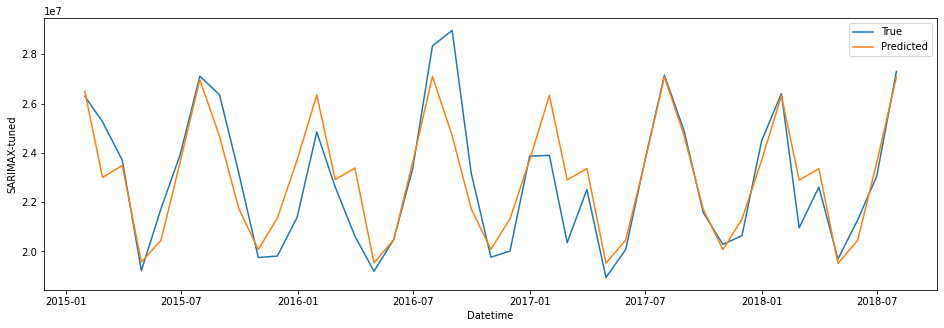

In [209]:
plot_test(df_test_final['PJME_MW'], df_test_final['SARIMAX-tuned'], df_test_final)

# Compare Results

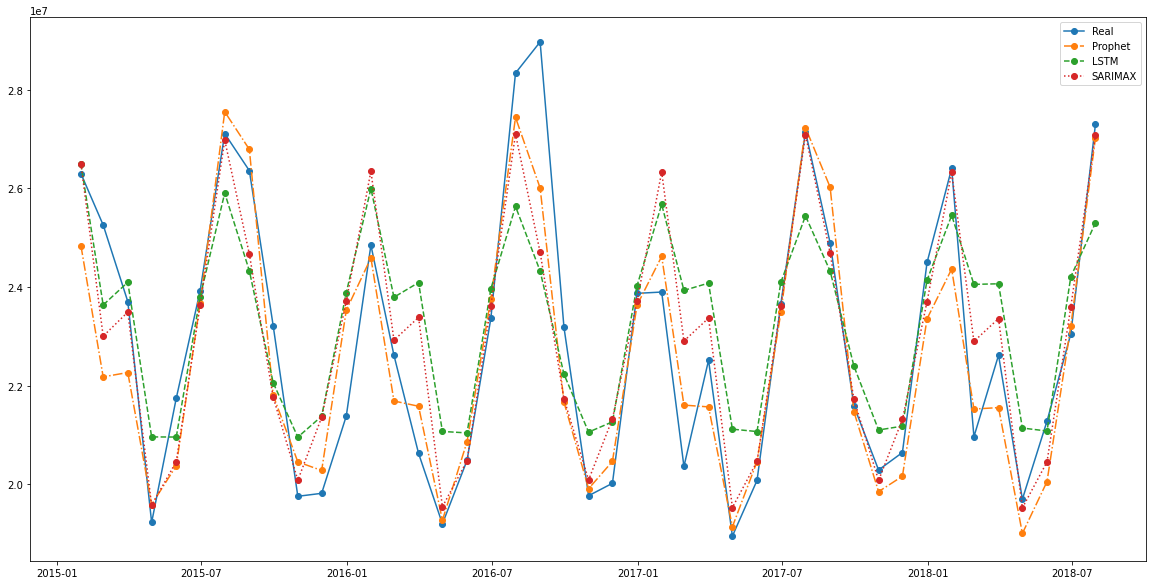

In [210]:
plt.figure(figsize=(20,10))
plt.plot_date(df_test_final.index, df_test_final["PJME_MW"], linestyle="-", label = "Real")
plt.plot_date(df_test_final.index, df_test_final["Prophet"], linestyle="-.", label = "Prophet")
plt.plot_date(df_test_final.index, df_test_final["LSTM_Predictions"], linestyle="--", label = "LSTM")
plt.plot_date(df_test_final.index, df_test_final["SARIMAX-tuned"], linestyle=":", label = "SARIMAX")
plt.legend()
plt.show()

In [211]:
df_performance

,model,MSE,MAE,MAPE,R2
0,Prophet,1.201623e+12,8.330009e+05,3.569938,0.837517
1,Prophet-holiday,1.210322e+12,8.322054e+05,3.564228,0.836341
2,LSTM,2.901589e+12,1.393993e+06,6.175442,0.607649
3,SARIMAX,1.856683e+12,1.117549e+06,4.979453,0.748940
4,SARIMAX-tuned,1.719822e+12,9.172914e+05,4.013471,0.767447
